---

# Codebook

In [60]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from collections import Counter
import re
import os

def load_data(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):

            # Load CSV and add chart_date column
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, engine='python', encoding='utf-8')
            # print(f"Loaded {file_path} with shape {df.shape}")

            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Load data
hot100 = load_data('./final-csv/hot-100')  # adjust path as needed
global200 = load_data('./final-csv/global-200')  # adjust path as needed

# Helper functions (use your regex-based ones)
def is_korean(word):
    return bool(re.search(r'[\uac00-\ud7af]', word))

def is_english(word):
    return bool(re.search(r'[a-zA-Z]', word))

def get_korean_ratio(text):
    words = re.findall(r'\b\w+\b', str(text))
    if not words:
        return 0
    korean_count = sum(1 for w in words if is_korean(w))
    return korean_count / len(words)

def get_english_ratio(text):
    words = re.findall(r'\b\w+\b', str(text))
    if not words:
        return 0
    english_count = sum(1 for w in words if is_english(w))
    return english_count / len(words)

def count_filler_words(text, filler_words):
    words = re.findall(r'\b\w+\b', str(text).lower())
    return sum(1 for w in words if w in filler_words)
import re

def is_korean(word):
    return bool(re.search(r'[\uac00-\ud7af]', word))

def is_english(word):
    return bool(re.search(r'[a-zA-Z]', word))

def classify_word_regex(word):
    if is_korean(word):
        return 'KOREAN'
    elif is_english(word):
        return 'ENGLISH'
    else:
        return 'OTHER'

def count_word_level_language_switches(text):
    words = re.findall(r'\b\w+\b', str(text))
    langs = [classify_word_regex(w) for w in words if classify_word_regex(w) in ['KOREAN', 'ENGLISH']]
    return sum(1 for i in range(len(langs)-1) if langs[i] != langs[i+1])

# Alliteration (English only, as before)
from nltk.corpus import cmudict

cmu_dict = cmudict.dict()
def get_first_phoneme(word):
    word = word.lower()
    if word in cmu_dict:
        return cmu_dict[word][0][0]
    return None
def count_alliterations(text):
    words = nltk.word_tokenize(str(text))
    phonemes = [get_first_phoneme(word) for word in words]
    filtered = [ph for ph in phonemes if ph is not None]
    count = 0
    for i in range(len(filtered)-1):
        if filtered[i] == filtered[i+1]:
            count += 1
    return count

# Repetitions (word/phrase/sentence)
def count_consecutive_repetitions(text, max_ngram=5):
    tokens = str(text).split()
    total_rep = 0
    rep_dict = {}
    i = 0
    n_tokens = len(tokens)
    while i < n_tokens:
        found_repeat = False
        for n in range(max_ngram, 0, -1):
            if i + n > n_tokens:
                continue
            current_ngram = tokens[i:i+n]
            rep_count = 0
            j = i + n
            while j + n <= n_tokens and tokens[j:j+n] == current_ngram:
                rep_count += 1
                j += n
            if rep_count > 0:
                phrase = " ".join(current_ngram)
                total_rep += rep_count
                rep_dict[phrase] = rep_dict.get(phrase, 0) + rep_count
                i = j
                found_repeat = True
                break
        if not found_repeat:
            i += 1
    # Sentence-level
    sentences = sent_tokenize(str(text))
    i = 0
    n_sent = len(sentences)
    while i < n_sent - 1:
        rep_count = 0
        j = i + 1
        while j < n_sent and sentences[j].strip() == sentences[i].strip():
            rep_count += 1
            j += 1
        if rep_count > 0:
            phrase = sentences[i].strip()
            total_rep += rep_count
            rep_dict[phrase] = rep_dict.get(phrase, 0) + rep_count
            i = j
        else:
            i += 1
    return total_rep, rep_dict

def count_repetitions(text):
    return count_consecutive_repetitions(text, max_ngram=5)

# Filler words list (customize as needed)
filler_words = []
with open("./filler.txt", "r") as f:
    # if the element is "", it will be skipped
    for line in f:
        if line.strip() == "":
            continue
        # print(line)
        filler_words.append(line.strip())
filler_words.sort()

# Apply features
for df in [hot100, global200]:
    df['kor_ratio'] = df['Cleaned Lyrics'].fillna('').apply(get_korean_ratio)
    df['eng_ratio'] = df['Cleaned Lyrics'].fillna('').apply(get_english_ratio)
    df['filler_count'] = df['Cleaned Lyrics'].fillna('').apply(lambda x: count_filler_words(x, filler_words))
    df['alliteration_count'] = df['Cleaned Lyrics'].fillna('').apply(count_alliterations)
    df['repetition_count'], df['repetition_dict'] = zip(*df['Cleaned Lyrics'].fillna('').apply(count_repetitions))
    df['Gender_enc'] = np.where(df['Gender'] == 'F', 1, 0)
    df['Category_enc'] = np.where(df['Category'] == 'S', 1, 0)
    df['code_switches'] = df['Cleaned Lyrics'].fillna('').apply(count_word_level_language_switches)

## Classification using `xlm-roberta-base`

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

def get_lyrics_features(X):
    # get embeddings from xlm-roberta-base
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
    model = AutoModel.from_pretrained('xlm-roberta-base')
    embeddings = []
    for lyrics in X:
        inputs = tokenizer(lyrics, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return np.array(embeddings)

def run_multiple_classifiers(X, y, indices, target_names=['Boy', 'Girl']):
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, stratify=y, random_state=42)
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "MLP (Neural Net)": MLPClassifier(max_iter=500),
        "SVM": SVC(probability=True),
        "Voting Classifier": VotingClassifier(
            estimators=[('lr', LogisticRegression(max_iter=1000)),
                        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                        ('mlp', MLPClassifier(max_iter=500))],
            voting='soft'
        )
    }
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        print(f"\n{name}")
        print(classification_report(y_test, y_pred, target_names=target_names))
        results[name] = {
            'model': model,
            'y_pred': y_pred,
            'X_test': X_test,
            'y_test': y_test,
            'idx_test': idx_test,
            'accuracy': acc,
            'macro_f1': macro_f1
        }
    return results

# Prepare your features as before
def prepare_features(df, features=None):
    if features is None:
        features = ['kor_ratio', 'eng_ratio', 'filler_count', 'alliteration_count', 'repetition_count', 'code_switches']
    X = df[features]
    X_lyrics = get_lyrics_features(df['Cleaned Lyrics'])
    X_pca = PCA(n_components=30).fit_transform(X_lyrics)
    X = np.concatenate([X, X_pca], axis=1)
    y = df['Gender_enc']
    indices = df.index
    return X, y, indices

print("Hot 100 Classification with Multiple Models:")
X_hot, y_hot, indices_hot = prepare_features(hot100)
hot100_results = run_multiple_classifiers(X_hot, y_hot, indices_hot)
best_model_name_100 = max(hot100_results, key=lambda k: hot100_results[k]['macro_f1'])
print(f"Best model for Hot 100: {best_model_name_100} (Macro F1: {hot100_results[best_model_name_100]['macro_f1']:.3f})")

print("\nGlobal 200 Classification with Multiple Models:")
X_global, y_global, indices_global = prepare_features(global200)
global200_results = run_multiple_classifiers(X_global, y_global, indices_global)
best_model_name_200 = max(global200_results, key=lambda k: global200_results[k]['macro_f1'])
print(f"Best model for Global 200: {best_model_name_200} (Macro F1: {global200_results[best_model_name_200]['macro_f1']:.3f})")

Hot 100 Classification with Multiple Models:

Logistic Regression
              precision    recall  f1-score   support

         Boy       0.69      0.90      0.78        10
        Girl       0.75      0.43      0.55         7

    accuracy                           0.71        17
   macro avg       0.72      0.66      0.66        17
weighted avg       0.72      0.71      0.68        17


Random Forest
              precision    recall  f1-score   support

         Boy       0.62      0.80      0.70        10
        Girl       0.50      0.29      0.36         7

    accuracy                           0.59        17
   macro avg       0.56      0.54      0.53        17
weighted avg       0.57      0.59      0.56        17


XGBoost
              precision    recall  f1-score   support

         Boy       0.54      0.70      0.61        10
        Girl       0.25      0.14      0.18         7

    accuracy                           0.47        17
   macro avg       0.39      0.42     

## Misclassification analysis

In [ ]:
def analyze_misclassifications(df, test_idx, y_test, y_pred):
    df_test = df.loc[test_idx].copy()
    df_test['true_label'] = y_test
    df_test['pred_label'] = y_pred
    false_pos = df_test[(df_test['true_label'] == 0) & (df_test['pred_label'] == 1)]
    false_neg = df_test[(df_test['true_label'] == 1) & (df_test['pred_label'] == 0)]
    print(f"False Positives (Boy predicted as Girl): {len(false_pos)}")
    print(false_pos[['artist', 'title', 'Cleaned Lyrics']].head())
    print(f"\nFalse Negatives (Girl predicted as Boy): {len(false_neg)}")
    print(false_neg[['artist', 'title', 'Cleaned Lyrics']].head())
    return false_pos, false_neg

print("Hot 100 Misclassifications:")
hot100_fp, hot100_fn = analyze_misclassifications(
    hot100, 
    hot100_results[best_model_name_100]['idx_test'],  # pass indices, not X_test
    hot100_results[best_model_name_100]['y_test'],
    hot100_results[best_model_name_100]['y_pred']
)
print("\nGlobal 200 Misclassifications:")
global200_fp, global200_fn = analyze_misclassifications(
    global200,
    global200_results[best_model_name_200]['idx_test'],  # pass indices, not X_test
    global200_results[best_model_name_200]['y_test'],
    global200_results[best_model_name_200]['y_pred']
)

## Classification using `gte-multilingual-base`

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

def get_lyrics_features(X):
    # get embeddings from xlm-roberta-base
    tokenizer = AutoTokenizer.from_pretrained('Alibaba-NLP/gte-multilingual-base', trust_remote_code=True)
    model = AutoModel.from_pretrained('Alibaba-NLP/gte-multilingual-base', trust_remote_code=True)
    embeddings = []
    for lyrics in X:
        inputs = tokenizer(lyrics, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return np.array(embeddings)

def run_multiple_classifiers(X, y, indices, target_names=['Boy', 'Girl']):
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, stratify=y, random_state=42)
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "MLP (Neural Net)": MLPClassifier(max_iter=500),
        "SVM": SVC(probability=True),
        "Voting Classifier": VotingClassifier(
            estimators=[('lr', LogisticRegression(max_iter=1000)),
                        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                        ('mlp', MLPClassifier(max_iter=500))],
            voting='soft'
        )
    }
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        print(f"\n{name}")
        print(classification_report(y_test, y_pred, target_names=target_names))
        results[name] = {
            'model': model,
            'y_pred': y_pred,
            'X_test': X_test,
            'y_test': y_test,
            'idx_test': idx_test,
            'accuracy': acc,
            'macro_f1': macro_f1
        }
    return results

# Prepare your features as before
def prepare_features(df, features=None):
    if features is None:
        features = ['kor_ratio', 'eng_ratio', 'filler_count', 'alliteration_count', 'repetition_count', 'code_switches']
    X = df[features]
    X_lyrics = get_lyrics_features(df['Cleaned Lyrics'])
    X_pca = PCA(n_components=30).fit_transform(X_lyrics)
    X = np.concatenate([X, X_pca], axis=1)
    y = df['Gender_enc']
    indices = df.index
    return X, y, indices

print("Hot 100 Classification with Multiple Models:")
X_hot, y_hot, indices_hot = prepare_features(hot100)
hot100_results = run_multiple_classifiers(X_hot, y_hot, indices_hot)
best_model_name_100 = max(hot100_results, key=lambda k: hot100_results[k]['macro_f1'])
print(f"Best model for Hot 100: {best_model_name_100} (Macro F1: {hot100_results[best_model_name_100]['macro_f1']:.3f})")

print("\nGlobal 200 Classification with Multiple Models:")
X_global, y_global, indices_global = prepare_features(global200)
global200_results = run_multiple_classifiers(X_global, y_global, indices_global)
best_model_name_200 = max(global200_results, key=lambda k: global200_results[k]['macro_f1'])
print(f"Best model for Global 200: {best_model_name_200} (Macro F1: {global200_results[best_model_name_200]['macro_f1']:.3f})")

Hot 100 Classification with Multiple Models:


Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Logistic Regression
              precision    recall  f1-score   support

         Boy       0.75      0.60      0.67        10
        Girl       0.56      0.71      0.62         7

    accuracy                           0.65        17
   macro avg       0.65      0.66      0.65        17
weighted avg       0.67      0.65      0.65        17


Random Forest
              precision    recall  f1-score   support

         Boy       0.69      0.90      0.78        10
        Girl       0.75      0.43      0.55         7

    accuracy                           0.71        17
   macro avg       0.72      0.66      0.66        17
weighted avg       0.72      0.71      0.68        17


XGBoost
              precision    recall  f1-score   support

         Boy       0.70      0.70      0.70        10
        Girl       0.57      0.57      0.57         7

    accuracy                           0.65        17
   macro avg       0.64      0.64      0.64        17
weighted avg       0.65      

Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Logistic Regression
              precision    recall  f1-score   support

         Boy       0.71      0.59      0.65        17
        Girl       0.73      0.83      0.78        23

    accuracy                           0.72        40
   macro avg       0.72      0.71      0.71        40
weighted avg       0.72      0.72      0.72        40


Random Forest
              precision    recall  f1-score   support

         Boy       0.73      0.47      0.57        17
        Girl       0.69      0.87      0.77        23

    accuracy                           0.70        40
   macro avg       0.71      0.67      0.67        40
weighted avg       0.71      0.70      0.69        40


XGBoost
              precision    recall  f1-score   support

         Boy       0.61      0.65      0.63        17
        Girl       0.73      0.70      0.71        23

    accuracy                           0.68        40
   macro avg       0.67      0.67      0.67        40
weighted avg       0.68      

In [61]:
def analyze_misclassifications(df, test_idx, y_test, y_pred):
    df_test = df.loc[test_idx].copy()
    df_test['true_label'] = y_test
    df_test['pred_label'] = y_pred
    false_pos = df_test[(df_test['true_label'] == 0) & (df_test['pred_label'] == 1)]
    false_neg = df_test[(df_test['true_label'] == 1) & (df_test['pred_label'] == 0)]
    print(f"False Positives (Boy predicted as Girl): {len(false_pos)}")
    print(false_pos[['artist', 'title', 'Cleaned Lyrics']].head())
    print(f"\nFalse Negatives (Girl predicted as Boy): {len(false_neg)}")
    print(false_neg[['artist', 'title', 'Cleaned Lyrics']].head())
    return false_pos, false_neg

print("Hot 100 Misclassifications:")
hot100_fp, hot100_fn = analyze_misclassifications(
    hot100, 
    hot100_results[best_model_name_100]['idx_test'],  # pass indices, not X_test
    hot100_results[best_model_name_100]['y_test'],
    hot100_results[best_model_name_100]['y_pred']
)
print("\nGlobal 200 Misclassifications:")
global200_fp, global200_fn = analyze_misclassifications(
    global200,
    global200_results[best_model_name_200]['idx_test'],  # pass indices, not X_test
    global200_results[best_model_name_200]['y_test'],
    global200_results[best_model_name_200]['y_pred']
)

Hot 100 Misclassifications:
False Positives (Boy predicted as Girl): 3
    artist                title  \
14     bts            fake love   
30  j-hope  chicken noodle soup   
7        v        love me again   

                                       Cleaned Lyrics  
14  널 위해서라면 난\n슬퍼도 기쁜 척 할 수가 있었어\n널 위해서라면 난\n아파도 강...  
30  Chicken noodle soup\nChicken noodle soup\nChic...  
7   추억도 의미 없이\n내게 넌 사라지고\n이쯤에도 I can't let you go,...  

False Negatives (Girl predicted as Boy): 1
         artist title                                     Cleaned Lyrics
35  le sserafim  easy  다친대도, 길을 걸어, kiss me\n쉽지 않음 내가 쉽게 easy\nStage,...

Global 200 Misclassifications:
False Positives (Boy predicted as Girl): 7
         artist         title  \
52   stray kids  chk chk boom   
18            v     fri(end)s   
122     enhypen   sweet venom   
53   stray kids        maniac   
10    jung kook      hate you   

                                        Cleaned Lyrics  
52   Boom, boom, chk, chk, boom\n(Brrah) 정중

## Ratio analysis in lyrics
- Analyzing the ratio of Korean and English words in the lyrics of hot-100.
- Analyzing the ratio of Korean and English words in the lyrics of global-200.

In [62]:
def group_phrase_stats(df, group_col='Category', gender_col='Gender'):
    # Korean/English ratio
    print(df.groupby([group_col, gender_col])[['kor_ratio', 'eng_ratio']].mean())
    # Most common phrases (bigrams)
    for (g, gender), group_df in df.groupby([group_col, gender_col]):
        all_lyrics = ' '.join(group_df['Cleaned Lyrics'].dropna())
        bigrams = [' '.join(pair) for pair in zip(all_lyrics.split()[:-1], all_lyrics.split()[1:])]
        bigram_counts = Counter(bigrams)
        print(f"\nMost common bigrams for {g} {gender}:")
        print(bigram_counts.most_common(10))

print("Hot 100 Group/Solo & Gender Stats:")
group_phrase_stats(hot100)
print("\nGlobal 200 Group/Solo & Gender Stats:")
group_phrase_stats(global200)

Hot 100 Group/Solo & Gender Stats:
                 kor_ratio  eng_ratio
Category Gender                      
G        F        0.177550   0.822619
         M        0.357985   0.617417
S        F        0.035586   0.963222
         M        0.106725   0.893128

Most common bigrams for G F:
[('I know', 35), ('on my', 27), ('I, boy,', 24), ('I got', 24), ('it, whip', 24), ('All the', 21), ('all the', 20), ('you like', 19), ('Moonlight sunrise', 17), ('make you', 17)]

Most common bigrams for G M:
[('I know', 19), ('Oh, oh,', 18), ('make it', 17), ('bring the', 16), ('in the', 15), ('I can', 15), ('fake love,', 14), ('love, fake', 14), ('me now', 14), ('yeah, yeah,', 14)]

Most common bigrams for S F:
[('아파트, 아파트', 30), ('ladies run', 23), ("I'm a", 21), ('JENNIE, JENNIE,', 20), ('on the', 20), ('아파트 아파트,', 20), ('be born', 18), ('my ladies', 15), ('call me', 15), ('the ground', 14)]

Most common bigrams for S M:
[('go, go,', 50), ('Chicken noodle', 30), ('noodle soup', 30), ('I like', 

## Statistical Analysis
- Using statistical analysis to analyze the data.
- Using t-test to analyze the data.
- Using Mann-Whitney U test to analyze the data.
- Using Shapiro-Wilk test to analyze the data.

In [5]:
# Do boy groups and girl groups differ in the amount of code-switching in their lyrics?
# Do boy groups and girl groups differ in the proportion of Korean lyrics in their songs?

from scipy.stats import ttest_ind, shapiro, mannwhitneyu

def run_statistical_analysis(df, feature, group_col='Gender_enc'):
    group0 = df[df[group_col] == 0][feature].dropna()
    group1 = df[df[group_col] == 1][feature].dropna()
    print(f"\nAnalyzing feature: {feature}")
    print(f"Group 0 mean: {group0.mean():.2f}")
    print(f"Group 1 mean: {group1.mean():.2f}")
    # Welch's t-test
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"Welch t-test: t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
    # Shapiro-Wilk normality test
    stat0, p0 = shapiro(group0)
    stat1, p1 = shapiro(group1)
    print(f"Group 0 normality p-value: {p0:.4f}")
    print(f"Group 1 normality p-value: {p1:.4f}")
    # Mann-Whitney U test
    u_stat, p_u = mannwhitneyu(group0, group1, alternative='two-sided')
    print(f"Mann-Whitney U statistic: {u_stat:.2f}, p-value: {p_u:.4f}")

# Example usage:
run_statistical_analysis(hot100, 'code_switches')
run_statistical_analysis(hot100, 'kor_ratio')


Analyzing feature: code_switches
Group 0 mean: 19.05
Group 1 mean: 16.96
Welch t-test: t-statistic: 0.41, p-value: 0.6862
Group 0 normality p-value: 0.0001
Group 1 normality p-value: 0.0002
Mann-Whitney U statistic: 555.50, p-value: 0.6109

Analyzing feature: kor_ratio
Group 0 mean: 0.24
Group 1 mean: 0.11
Welch t-test: t-statistic: 2.68, p-value: 0.0097
Group 0 normality p-value: 0.0002
Group 1 normality p-value: 0.0006
Mann-Whitney U statistic: 646.00, p-value: 0.0796


In [63]:
# Do boy groups and girl groups differ in the amount of code-switching in their lyrics?
# Do boy groups and girl groups differ in the proportion of Korean lyrics in their songs?

from scipy.stats import ttest_ind, shapiro, mannwhitneyu

def run_statistical_analysis(df, feature, group_col='Gender_enc'):
    group0 = df[df[group_col] == 0][feature].dropna()
    group1 = df[df[group_col] == 1][feature].dropna()
    print(f"\nAnalyzing feature: {feature}")
    print(f"Group 0 mean: {group0.mean():.2f}")
    print(f"Group 1 mean: {group1.mean():.2f}")
    # Welch's t-test
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"Welch t-test: t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
    # Shapiro-Wilk normality test
    stat0, p0 = shapiro(group0)
    stat1, p1 = shapiro(group1)
    print(f"Group 0 normality p-value: {p0:.4f}")
    print(f"Group 1 normality p-value: {p1:.4f}")
    # Mann-Whitney U test
    u_stat, p_u = mannwhitneyu(group0, group1, alternative='two-sided')
    print(f"Mann-Whitney U statistic: {u_stat:.2f}, p-value: {p_u:.4f}")

# Example usage:
run_statistical_analysis(global200, 'code_switches')
run_statistical_analysis(global200, 'kor_ratio')


Analyzing feature: code_switches
Group 0 mean: 20.57
Group 1 mean: 25.32
Welch t-test: t-statistic: -1.20, p-value: 0.2312
Group 0 normality p-value: 0.0000
Group 1 normality p-value: 0.0000
Mann-Whitney U statistic: 2960.50, p-value: 0.6341

Analyzing feature: kor_ratio
Group 0 mean: 0.24
Group 1 mean: 0.17
Welch t-test: t-statistic: 1.93, p-value: 0.0558
Group 0 normality p-value: 0.0000
Group 1 normality p-value: 0.0000
Mann-Whitney U statistic: 3547.00, p-value: 0.1054


- **RQ1:** Do boy groups and girl groups differ in the amount of code-switching in their lyrics?
- **RQ2:** Do boy groups and girl groups differ in the proportion of Korean lyrics in their songs?


## **Summary of Results**

### **A. Code-Switching**

- **Means:**  
  - Boy groups: 19.05  
  - Girl groups: 16.96
- **Welch’s t-test:**  
  - t = 0.41, p = 0.6862
- **Shapiro-Wilk normality:**  
  - Both p < 0.001 (not normal)
- **Mann-Whitney U test:**  
  - U = 555.50, p = 0.6109

**Interpretation:**  
- The mean code-switching count is slightly higher for boy groups, but the difference is **not statistically significant** (p > 0.05) in both the t-test and the Mann-Whitney U test.
- The distributions are not normal, so the Mann-Whitney U test is more reliable.
- **Conclusion:** We fail to reject the null hypothesis; there is no significant difference in code-switching frequency between boy and girl groups.

---

### **B. Korean Lyric Ratio**

- **Means:**  
  - Boy groups: 0.24  
  - Girl groups: 0.11
- **Welch’s t-test:**  
  - t = 2.68, p = 0.0097
- **Shapiro-Wilk normality:**  
  - Both p < 0.001 (not normal)
- **Mann-Whitney U test:**  
  - U = 646.00, p = 0.0796

**Interpretation:**  
- The mean Korean lyric ratio is higher for boy groups (0.24) than for girl groups (0.11).
- The t-test suggests a significant difference (p = 0.0097), but the data are not normal.
- The Mann-Whitney U test, which is more appropriate here, gives p = 0.0796 (**not significant at the 0.05 level**).
- **Conclusion:** We fail to reject the null hypothesis; there is no statistically significant difference in the proportion of Korean lyrics between boy and girl groups, although the difference is numerically notable and approaches significance.

---

### How i might write this in the paper

We compared both the frequency of code-switching and the proportion of Korean lyrics between boy and girl groups in Hot 100 songs. The mean code-switching count was 19.05 for boy groups and 16.96 for girl groups, while the mean Korean lyric ratio was 0.24 for boy groups and 0.11 for girl groups. Welch’s t-test suggested a significant difference in Korean lyric ratio (t = 2.68, p = 0.0097), but not in code-switching (t = 0.41, p = 0.6862). However, the Shapiro-Wilk test indicated that the distributions of both features were not normal (p < 0.001 for all groups). Therefore, we relied on the non-parametric Mann-Whitney U test, which found no significant difference for either code-switching (U = 555.50, p = 0.6109) or Korean lyric ratio (U = 646.00, p = 0.0796). Thus, we fail to reject the null hypothesis and conclude that there is no statistically significant difference between boy and girl groups in either code-switching frequency or the proportion of Korean lyrics in Hot 100 songs, although the difference in Korean lyric ratio approaches significance.

---


- **Statistical best practice:** When normality is violated, non-parametric tests are preferred.
- **"Fail to reject the null hypothesis":** This is the correct language when p > 0.05.
- **Reporting means:** Shows the numerical trend, even if not statistically significant.
- **Reporting both tests:** Demonstrates rigor and transparency.


"The difference in Korean lyric ratio approaches statistical significance (p = 0.0796), suggesting a possible trend for boy groups to use more Korean lyrics than girl groups, but this did not reach the conventional threshold for significance."



In [6]:
# Is there a difference in the proportion of Korean lyrics (kor_ratio) between Hot 100 and Global 200 charts for boy and girl groups?
from scipy.stats import ttest_ind, shapiro, mannwhitneyu

def compare_kor_ratio_between_charts(hot100, global200, gender_enc, gender_label):
    # Filter by gender
    hot_kor = hot100[hot100['Gender_enc'] == gender_enc]['kor_ratio'].dropna()
    global_kor = global200[global200['Gender_enc'] == gender_enc]['kor_ratio'].dropna()
    print(f"\n{gender_label} groups:")
    print(f"  Hot 100 mean kor_ratio: {hot_kor.mean():.3f}")
    print(f"  Global 200 mean kor_ratio: {global_kor.mean():.3f}")
    # Welch's t-test
    t_stat, p_val = ttest_ind(hot_kor, global_kor, equal_var=False)
    print(f"  Welch t-test: t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
    # Shapiro-Wilk normality
    p_hot = shapiro(hot_kor)[1]
    p_global = shapiro(global_kor)[1]
    print(f"  Hot 100 normality p-value: {p_hot:.4f}")
    print(f"  Global 200 normality p-value: {p_global:.4f}")
    # Mann-Whitney U test
    u_stat, p_u = mannwhitneyu(hot_kor, global_kor, alternative='two-sided')
    print(f"  Mann-Whitney U statistic: {u_stat:.2f}, p-value: {p_u:.4f}")

# Run for both genders
compare_kor_ratio_between_charts(hot100, global200, gender_enc=0, gender_label="Boy")
compare_kor_ratio_between_charts(hot100, global200, gender_enc=1, gender_label="Girl")


Boy groups:
  Hot 100 mean kor_ratio: 0.236
  Global 200 mean kor_ratio: 0.238
  Welch t-test: t-statistic: -0.05, p-value: 0.9599
  Hot 100 normality p-value: 0.0002
  Global 200 normality p-value: 0.0000
  Mann-Whitney U statistic: 1234.00, p-value: 0.8717

Girl groups:
  Hot 100 mean kor_ratio: 0.112
  Global 200 mean kor_ratio: 0.171
  Welch t-test: t-statistic: -2.00, p-value: 0.0498
  Hot 100 normality p-value: 0.0006
  Global 200 normality p-value: 0.0000
  Mann-Whitney U statistic: 1076.00, p-value: 0.1995


Research Question:
- Is there a difference in the proportion of Korean lyrics (kor_ratio) between Hot 100 and Global 200 charts for boy and girl groups?

Hypotheses (for each gender):
- Null hypothesis (H₀):
    The mean Korean lyric ratio is the same for Hot 100 and Global 200 songs.
    (μ_hot100 = μ_global200)
- Alternative hypothesis (H₁):
    The mean Korean lyric ratio is different between Hot 100 and Global 200 songs.
    (μ_hot100 ≠ μ_global200)
--

### **A. Boy Groups**

- **Hot 100 mean kor_ratio:** 0.236  
- **Global 200 mean kor_ratio:** 0.238  
- **Welch’s t-test:** t = -0.05, p = 0.9599  
- **Shapiro-Wilk normality:** Both p < 0.001 (not normal)
- **Mann-Whitney U test:** U = 1234.00, p = 0.8717

**Interpretation:**  
- The mean Korean lyric ratio is nearly identical for boy groups on both charts.
- Both the t-test and Mann-Whitney U test show **no significant difference** (p ≫ 0.05).
- **Conclusion:** We fail to reject the null hypothesis; there is no significant difference in the proportion of Korean lyrics for boy groups between the Hot 100 and Global 200 charts.

### **B. Girl Groups**

- **Hot 100 mean kor_ratio:** 0.112  
- **Global 200 mean kor_ratio:** 0.171  
- **Welch’s t-test:** t = -2.00, p = 0.0498  
- **Shapiro-Wilk normality:** Both p < 0.001 (not normal)
- **Mann-Whitney U test:** U = 1076.00, p = 0.1995

**Interpretation:**  
- The mean Korean lyric ratio is higher for girl groups on the Global 200 (0.171) than on the Hot 100 (0.112).
- The t-test suggests a borderline significant difference (p = 0.0498), but the data are not normal.
- The Mann-Whitney U test, which is more appropriate, gives p = 0.1995 (**not significant**).
- **Conclusion:** We fail to reject the null hypothesis; there is no statistically significant difference in the proportion of Korean lyrics for girl groups between the Hot 100 and Global 200 charts, although the numerical difference is notable.



## 3. **How i might write this in the paper**

We compared the proportion of Korean lyrics (kor_ratio) between Hot 100 and Global 200 charts for both boy and girl groups. For boy groups, the mean kor_ratio was nearly identical (Hot 100: 0.236, Global 200: 0.238), and neither Welch’s t-test (p = 0.9599) nor the Mann-Whitney U test (p = 0.8717) indicated a significant difference. For girl groups, the mean kor_ratio was higher on the Global 200 (0.171) than on the Hot 100 (0.112). While Welch’s t-test suggested a borderline significant difference (p = 0.0498), the Shapiro-Wilk test indicated that the data were not normally distributed (p < 0.001 for both groups). The Mann-Whitney U test, which does not assume normality, found no significant difference (p = 0.1995). Thus, we fail to reject the null hypothesis and conclude that there is no statistically significant difference in the proportion of Korean lyrics between the two charts for either boy or girl groups, although the difference for girl groups is numerically notable.

---

## 4. **Why This Interpretation?**

- **Statistical best practice:** When normality is violated, rely on the non-parametric test.
- **"Fail to reject the null hypothesis":** Correct language when p > 0.05.
- **Reporting means:** Shows the numerical trend, even if not statistically significant.
- **Reporting both tests:** Demonstrates rigor and transparency.

---

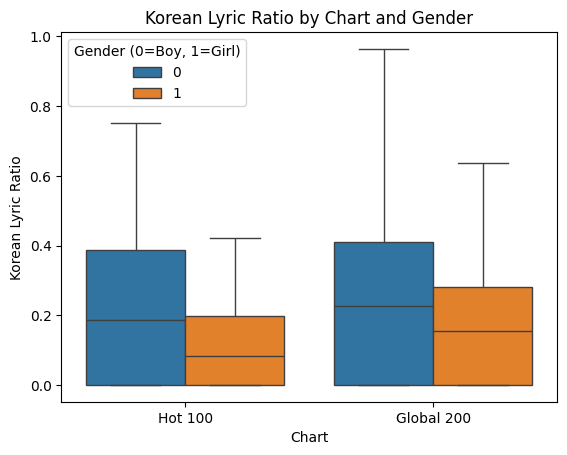

In [7]:
# Boxplot of kor_ratio by chart and gender
import seaborn as sns
import matplotlib.pyplot as plt

hot100['Chart'] = 'Hot 100'
global200['Chart'] = 'Global 200'
combined = pd.concat([hot100, global200])

sns.boxplot(x='Chart', y='kor_ratio', hue='Gender_enc', data=combined, showfliers=False)
plt.title('Korean Lyric Ratio by Chart and Gender')
plt.xlabel('Chart')
plt.ylabel('Korean Lyric Ratio')
plt.legend(title='Gender (0=Boy, 1=Girl)')
plt.show()

---